In [6]:
%matplotlib inline
import numpy as np
import scipy 
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import interpolate

In [7]:
# general properties
g = 9.81 # [m/s²] in positive x direction

# particle properties
d_p = 0.0002 # [m]
rho_s = 2500.0 # [kg/m³]
k_s = [11.9238701002, 1.19238701002, 0.119238701002] # [W/m·K]
c_s = 1000 # [J/kg·K]
A_p = np.pi * d_p ** 2.0 / 4.0 # [m²]
A = np.pi * d_p ** 2.0 # [m²]
V_p = 4.0 / 3.0 * np.pi * (d_p / 2.0) ** 3.0 # [m³]
T_p_0 = 500.0 # [K]
mass = rho_s * V_p # [kg]
print(mass)
R = d_p/2.0
heat_source = [0.0, 10000000000, 50000000000, 100000000000 ]


# fluid material properties
rho_f = 1000.0 # [kg/m³]
mu_f = 0.001 # [Pa·s]
k_f = 0.5 # [W/m·K]
c_f = 5000.0 # [J/kg·K]
T_f = 300.0 # [K]
Pr = c_f * mu_f / k_f

print(Pr)


#injection properties
len_inj = 0.0002 # [m]
wid_inj = 0.0002 # [m]
time_inj = 0.0001 # [s]
mass_flow_inj = mass/time_inj # [kg/s]
print(mass_flow_inj*1000*60*60, "g/h" )
mass_flow_ton = mass_flow_inj*60*60/1000 #[ton/h]
print(mass_flow_ton, "t/h")

#adimensionalizando o termo fonte
length = d_p
delta_t_rocky = 7.57753E-08
time = 1000*delta_t_rocky
accel= length/(time*time)
vol = length*length*length
force = mass*accel
energy = force*length
power = energy/time
power_density = power/vol
print(power_density)

non_dimentional_heat_source = np.array(heat_source)/power_density
print(non_dimentional_heat_source)

1.0471975511965978e-08
10.0
376.9911184307752 g/h
0.0003769911184307752 t/h
120341557.77590473
[   0.           83.09681364  415.48406821  830.96813643]


In [8]:
# helper functions

def SchillerNaumann1933(Re):
    # calculates CD using SchillerNaumann
    part1 = (24.0/(Re+0.00000001)) * (1 + 0.15 * Re**(0.687))
    part2 = 0.44
    cd = max(part1,part2)
    return cd

def Stokes(Re):
    # calculates CD using Stokes
    cd = 24.0/(Re+0.00000000001)
    return cd

def NewtonianDragTerminalVelocity(rho_s, rho_f, g, d_p):
    # Calculate terminal velocity estimated for a newtonian drag regime
    vel = 2.46 * (((rho_s - rho_f) * g * d_p/2.0 / rho_f)**0.5)
    #vel = (4.0/6)*((rho_s - rho_f) * g * d_p / rho_f * 0.44) 
    return vel

def StokesTerminalVelocity(rho_s, rho_f, g, d_p, mu_f):
    velStokes = (1.0/18)* ( rho_s - rho_f)* g *d_p*d_p/mu_f
    return velStokes

def residual(v_inf):
    Re = rho_f * v_inf * d_p / mu_f
    if regime ==1:
        C_D = SchillerNaumann1933(Re)
    elif regime == 2:
        C_D = Stokes(Re)
    
    delta_v = 0.5 * rho_f * A_p * C_D * v_inf * v_inf - (rho_s - rho_f) * V_p * g
    
    return delta_v

def Reynolds(rho, mu, L, U):
    Re = rho * U * L / mu
    return Re

def transient_velocity( vel, time, regime ):
    # Function to calculate velocity against time (to be numerically integrated)
    C1 = (g/rho_s)*(rho_s - rho_f)
    Re = rho_f * vel * d_p / mu_f
    if regime ==1:
        C_D = SchillerNaumann1933(Re)
    elif regime == 2:
        C_D = Stokes(Re)
        
    C2 = (0.5 * rho_f * A_p * C_D / (V_p * rho_s)) 
    return C1 - C2* vel* vel

def find_x_interpolate_given_f(interface, x, t):
    y_array = np.array(x)
    yreduced = y_array - interface
    freduced = interpolate.UnivariateSpline(t, yreduced, s=0)
    time_colision = freduced.roots()
    
    return time_colision

def find_f_interpolate_given_x(x_array, y_array, time):
    f = interpolate.interp1d(x_array, y_array)
    ynew = f(time)
    
    return ynew

def RanzMarshall(Re, Pr):
    Nu = 2.0 + 0.6 * Re ** 0.5 * Pr ** 0.333333333
    return Nu

def Whitaker(Re, Pr, mu_ratio = 1.0):
    Nu = 2.0 + (0.4 * Re ** 0.5 + 0.06 * Re ** 0.6666666666666667) * Pr ** 0.4 * mu_ratio ** 0.25
    return Nu;



In [9]:
# loading the digitized data

#standard formulation results

#heat source 0
rocky_data_one_way_padrao_hs_0 = open("falling_particle_padrao_RM_one_way.csv", 'r')
t_one_way_padrao_hs0, temp_one_way_padrao_hs0, particlez_one_way_padrao_hs0, velocity_one_way_padrao_hs0 = \
np.loadtxt(rocky_data_one_way_padrao_hs_0, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way_padrao_hs_0.close()


rocky_data_two_way_padrao_hs0 = open("falling_particle_padrao_RM_two_way.csv", 'r')
t_two_way_padrao_hs0, temp_two_way_padrao_hs0, particlez_two_way_padrao_hs0, velocity_two_way_padrao_hs0 = \
np.loadtxt(rocky_data_two_way_padrao_hs0, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_two_way_padrao_hs0.close()

#heat source 1
rocky_data_one_way_padrao_hs_1 = open("standard_1_way_hs1.csv", 'r')
t_one_way_padrao_hs1, temp_one_way_padrao_hs1, particlez_one_way_padrao_hs1, velocity_one_way_padrao_hs1 = \
np.loadtxt(rocky_data_one_way_padrao_hs_1, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_padrao_hs_1.close()

rocky_data_two_way_padrao_hs1 = open("standard_1_way_hs1.csv", 'r')
t_two_way_padrao_hs1, temp_two_way_padrao_hs1, particlez_two_way_padrao_hs1, velocity_two_way_padrao_hs1 = \
np.loadtxt(rocky_data_two_way_padrao_hs1, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_two_way_padrao_hs1.close()

#heat source 2
rocky_data_one_way_padrao_hs_2 = open("standard_1_way_hs2.csv", 'r')
t_one_way_padrao_hs2, temp_one_way_padrao_hs2, particlez_one_way_padrao_hs2, velocity_one_way_padrao_hs2 = \
np.loadtxt(rocky_data_one_way_padrao_hs_2, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_padrao_hs_2.close()

rocky_data_two_way_padrao_hs2 = open("falling_particle_padrao_RM_two_way.csv", 'r')
t_two_way_padrao_hs2, temp_two_way_padrao_hs2, particlez_two_way_padrao_hs2, velocity_two_way_padrao_hs2 = \
np.loadtxt(rocky_data_two_way_padrao_hs2, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_two_way_padrao_hs2.close()

#heat source 3
rocky_data_one_way_padrao_hs_3 = open("standard_1_way_hs3.csv", 'r')
t_one_way_padrao_hs3, temp_one_way_padrao_hs3, particlez_one_way_padrao_hs3, velocity_one_way_padrao_hs3 = \
np.loadtxt(rocky_data_one_way_padrao_hs_3, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_padrao_hs_3.close()


#improved formulation results

#heat source 0 

rocky_data_one_way_improved_Bi_01_hs_0 = open("improved_1_way_hs0_Bi01.csv", 'r')
t_one_way_improved_hs0_Bi01, temp_one_way_improved_hs0_Bi01, particlez_one_way_improved_hs0_Bi01, velocity_one_way_improved_hs0_Bi01 = \
np.loadtxt(rocky_data_one_way_improved_Bi_01_hs_0, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_01_hs_0.close()

rocky_data_one_way_improved_Bi_1_hs_0 = open("falling_particle_padrao_RM_one_way.csv", 'r')
t_one_way_improved_hs0_Bi1, temp_one_way_improved_hs0_Bi1, particlez_one_way_improved_hs0_Bi1, velocity_one_way_improved_hs0_Bi1 = \
np.loadtxt(rocky_data_one_way_improved_Bi_1_hs_0, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_1_hs_0.close()

rocky_data_one_way_improved_Bi_10_hs_0 = open("falling_particle_padrao_RM_one_way.csv", 'r')
t_one_way_improved_hs0_Bi10, temp_one_way_improved_hs0_Bi10, particlez_one_way_improved_hs0_Bi10, velocity_one_way_improved_hs0_Bi10 = \
np.loadtxt(rocky_data_one_way_improved_Bi_10_hs_0, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_10_hs_0.close()

#heat source 1 

rocky_data_one_way_improved_Bi_01_hs_1 = open("improved_1_way_hs1_Bi01.csv", 'r')
t_one_way_improved_hs1_Bi01, temp_one_way_improved_hs1_Bi01, particlez_one_way_improved_hs1_Bi01, velocity_one_way_improved_hs1_Bi01 = \
np.loadtxt(rocky_data_one_way_improved_Bi_01_hs_1, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_01_hs_1.close()

rocky_data_one_way_improved_Bi_1_hs_1 = open("improved_1_way_hs1_Bi1.csv", 'r')
t_one_way_improved_hs1_Bi1, temp_one_way_improved_hs1_Bi1, particlez_one_way_improved_hs1_Bi1, velocity_one_way_improved_hs1_Bi1 = \
np.loadtxt(rocky_data_one_way_improved_Bi_1_hs_1, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_1_hs_1.close()

rocky_data_one_way_improved_Bi_10_hs_1 = open("improved_1_way_hs1_Bi10.csv", 'r')
t_one_way_improved_hs1_Bi10, temp_one_way_improved_hs1_Bi10, particlez_one_way_improved_hs1_Bi10, velocity_one_way_improved_hs1_Bi10 = \
np.loadtxt(rocky_data_one_way_improved_Bi_10_hs_1, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_10_hs_1.close()

#heat source 2 

rocky_data_one_way_improved_Bi_01_hs_2 = open("improved_1_way_hs2_Bi01.csv", 'r')
t_one_way_improved_hs2_Bi01, temp_one_way_improved_hs2_Bi01, particlez_one_way_improved_hs2_Bi01, velocity_one_way_improved_hs2_Bi01 = \
np.loadtxt(rocky_data_one_way_improved_Bi_01_hs_2, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_01_hs_2.close()

rocky_data_one_way_improved_Bi_1_hs_2 = open("improved_1_way_hs2_Bi1.csv", 'r')
t_one_way_improved_hs2_Bi1, temp_one_way_improved_hs2_Bi1, particlez_one_way_improved_hs2_Bi1, velocity_one_way_improved_hs2_Bi1 = \
np.loadtxt(rocky_data_one_way_improved_Bi_1_hs_2, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_1_hs_2.close()

rocky_data_one_way_improved_Bi_10_hs_2 = open("improved_1_way_hs2_Bi10.csv", 'r')
t_one_way_improved_hs2_Bi10, temp_one_way_improved_hs2_Bi10, particlez_one_way_improved_hs2_Bi10, velocity_one_way_improved_hs2_Bi10 = \
np.loadtxt(rocky_data_one_way_improved_Bi_10_hs_2, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_10_hs_2.close()

#heat source 3 

rocky_data_one_way_improved_Bi_01_hs_3 = open("improved_1_way_hs3_Bi01.csv", 'r')
t_one_way_improved_hs3_Bi01, temp_one_way_improved_hs3_Bi01, particlez_one_way_improved_hs3_Bi01, velocity_one_way_improved_hs3_Bi01 = \
np.loadtxt(rocky_data_one_way_improved_Bi_01_hs_3, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_01_hs_3.close()

rocky_data_one_way_improved_Bi_1_hs_3 = open("improved_1_way_hs3_Bi1.csv", 'r')
t_one_way_improved_hs3_Bi1, temp_one_way_improved_hs3_Bi1, particlez_one_way_improved_hs3_Bi1, velocity_one_way_improved_hs3_Bi1 = \
np.loadtxt(rocky_data_one_way_improved_Bi_1_hs_3, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_1_hs_3.close()

rocky_data_one_way_improved_Bi_10_hs_3 = open("improved_1_way_hs3_Bi10.csv", 'r')
t_one_way_improved_hs3_Bi10, temp_one_way_improved_hs3_Bi10, particlez_one_way_improved_hs3_Bi10, velocity_one_way_improved_hs3_Bi10 = \
np.loadtxt(rocky_data_one_way_improved_Bi_10_hs_3, delimiter = ',', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_10_hs_3.close()




In [11]:
regime = 1
print("Terminal velocity using Newtonian =", NewtonianDragTerminalVelocity(rho_s, rho_f, g, d_p),  "[m/s] ")

print("\n Terminal velocity calculations: \n")
v_inf = fsolve(residual, 0.1)[0]

print("Particle terminal velocity =", v_inf, "[m/s] ")


#integrating to get velocity - standard formulation
#vel_water_one_way_RM = scipy.integrate.odeint(transient_velocity, velocity_one_way_RM[0], t_one_way_RM, (regime,)).reshape((t_one_way_RM.size))
vel_one_way_padrao_hs0 = scipy.integrate.odeint(transient_velocity, velocity_one_way_padrao_hs0[0], 
                                t_one_way_padrao_hs0, (regime,)).reshape((temp_one_way_padrao_hs0.size))
vel_one_way_padrao_hs1 = scipy.integrate.odeint(transient_velocity, velocity_one_way_padrao_hs1[0], 
                                t_one_way_padrao_hs1, (regime,)).reshape((temp_one_way_padrao_hs1.size))
vel_one_way_padrao_hs2 = scipy.integrate.odeint(transient_velocity, velocity_one_way_padrao_hs2[0], 
                                t_one_way_padrao_hs2, (regime,)).reshape((temp_one_way_padrao_hs2.size))
vel_one_way_padrao_hs3 = scipy.integrate.odeint(transient_velocity, velocity_one_way_padrao_hs3[0], 
                                t_one_way_padrao_hs3, (regime,)).reshape((temp_one_way_padrao_hs3.size))

#two_way
vel_two_way_padrao_hs0 = scipy.integrate.odeint(transient_velocity, velocity_two_way_padrao_hs0[0], 
                                t_two_way_padrao_hs0, (regime,)).reshape((t_two_way_padrao_hs0.size))
vel_two_way_padrao_hs1 = scipy.integrate.odeint(transient_velocity, velocity_two_way_padrao_hs1[0], 
                                t_two_way_padrao_hs1, (regime,)).reshape((t_two_way_padrao_hs1.size))
vel_two_way_padrao_hs2 = scipy.integrate.odeint(transient_velocity, velocity_two_way_padrao_hs2[0], 
                                t_two_way_padrao_hs2, (regime,)).reshape((t_two_way_padrao_hs2.size))

#integrating to get velocity - improved formulation
#vel_water_one_way_RM = scipy.integrate.odeint(transient_velocity, velocity_one_way_RM[0], t_one_way_RM, (regime,)).reshape((t_one_way_RM.size))
vel_one_way_improved_hs0_Bi_01 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_hs0_Bi01[0], 
                                t_one_way_improved_hs0_Bi01, (regime,)).reshape((t_one_way_improved_hs0_Bi01.size))

vel_one_way_improved_hs1_Bi_01 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_hs1_Bi01[0], 
                                t_one_way_improved_hs1_Bi01, (regime,)).reshape((t_one_way_improved_hs1_Bi01.size))

vel_one_way_improved_hs1_Bi_1 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_hs1_Bi1[0], 
                                t_one_way_improved_hs1_Bi01, (regime,)).reshape((t_one_way_improved_hs1_Bi1.size))

vel_one_way_improved_hs1_Bi_10 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_hs1_Bi10[0], 
                                t_one_way_improved_hs1_Bi10, (regime,)).reshape((t_one_way_improved_hs1_Bi10.size))

vel_one_way_improved_hs2_Bi_01 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_hs2_Bi01[0], 
                                t_one_way_improved_hs2_Bi01, (regime,)).reshape((t_one_way_improved_hs2_Bi01.size))

vel_one_way_improved_hs2_Bi_1 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_hs2_Bi1[0], 
                                t_one_way_improved_hs2_Bi01, (regime,)).reshape((t_one_way_improved_hs2_Bi1.size))

vel_one_way_improved_hs2_Bi_10 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_hs2_Bi10[0], 
                                t_one_way_improved_hs2_Bi10, (regime,)).reshape((t_one_way_improved_hs2_Bi10.size))

vel_one_way_improved_hs3_Bi_01 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_hs3_Bi01[0], 
                                t_one_way_improved_hs3_Bi01, (regime,)).reshape((t_one_way_improved_hs3_Bi01.size))

vel_one_way_improved_hs3_Bi_1 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_hs3_Bi1[0], 
                                t_one_way_improved_hs3_Bi01, (regime,)).reshape((t_one_way_improved_hs3_Bi1.size))

vel_one_way_improved_hs3_Bi_10 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_hs3_Bi10[0], 
                                t_one_way_improved_hs3_Bi10, (regime,)).reshape((t_one_way_improved_hs3_Bi10.size))

#calculating Reynolds number
#standard formulation
Reynolds_one_way_hs0 = Reynolds(rho_f, mu_f, d_p, vel_one_way_padrao_hs0)
Reynolds_one_way_hs1 = Reynolds(rho_f, mu_f, d_p, vel_one_way_padrao_hs1)
Reynolds_one_way_hs2 = Reynolds(rho_f, mu_f, d_p, vel_one_way_padrao_hs2)
Reynolds_one_way_hs3 = Reynolds(rho_f, mu_f, d_p, vel_one_way_padrao_hs3)

Reynolds_two_way_hs0 = Reynolds(rho_f, mu_f, d_p, vel_two_way_padrao_hs0)
Reynolds_two_way_hs1 = Reynolds(rho_f, mu_f, d_p, vel_two_way_padrao_hs1)
Reynolds_two_way_hs2 = Reynolds(rho_f, mu_f, d_p, vel_two_way_padrao_hs2)

#improved formulation
Reynolds_improved_one_way_hs0_Bi01 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_hs0_Bi_01)

Reynolds_improved_one_way_hs1_Bi01 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_hs1_Bi_01)
Reynolds_improved_one_way_hs1_Bi1 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_hs1_Bi_1)
Reynolds_improved_one_way_hs1_Bi10 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_hs1_Bi_10)

Reynolds_improved_one_way_hs2_Bi01 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_hs2_Bi_01)
Reynolds_improved_one_way_hs2_Bi1 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_hs2_Bi_1)
Reynolds_improved_one_way_hs2_Bi10 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_hs2_Bi_10)

Reynolds_improved_one_way_hs3_Bi01 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_hs3_Bi_01)
Reynolds_improved_one_way_hs3_Bi1 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_hs3_Bi_1)
Reynolds_improved_one_way_hs3_Bi10 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_hs3_Bi_10)

#calculating Nusselt number
#standard formulation
Nu_RM_hs0 = RanzMarshall(Reynolds_one_way_hs0, Pr)
Nu_RM_hs1 = RanzMarshall(Reynolds_one_way_hs1, Pr)
Nu_RM_hs2 = RanzMarshall(Reynolds_one_way_hs2, Pr)
Nu_RM_hs3 = RanzMarshall(Reynolds_one_way_hs3, Pr)

Nu_RM_2way_hs0 = RanzMarshall(Reynolds_two_way_hs0, Pr)
Nu_RM_2way_hs1 = RanzMarshall(Reynolds_two_way_hs1, Pr)
Nu_RM_2way_hs2 = RanzMarshall(Reynolds_two_way_hs2, Pr)

#improved formulation
Nu_RM_improved_1_way_hs0_Bi01 = RanzMarshall(Reynolds_improved_one_way_hs0_Bi01, Pr)

Nu_RM_improved_1_way_hs1_Bi01 = RanzMarshall(Reynolds_improved_one_way_hs1_Bi01, Pr)
Nu_RM_improved_1_way_hs1_Bi1 = RanzMarshall(Reynolds_improved_one_way_hs1_Bi1, Pr)
Nu_RM_improved_1_way_hs1_Bi10 = RanzMarshall(Reynolds_improved_one_way_hs1_Bi10, Pr)

Nu_RM_improved_1_way_hs2_Bi01 = RanzMarshall(Reynolds_improved_one_way_hs2_Bi01, Pr)
Nu_RM_improved_1_way_hs2_Bi1 = RanzMarshall(Reynolds_improved_one_way_hs2_Bi1, Pr)
Nu_RM_improved_1_way_hs2_Bi10 = RanzMarshall(Reynolds_improved_one_way_hs2_Bi10, Pr)

Nu_RM_improved_1_way_hs3_Bi01 = RanzMarshall(Reynolds_improved_one_way_hs3_Bi01, Pr)
Nu_RM_improved_1_way_hs3_Bi1 = RanzMarshall(Reynolds_improved_one_way_hs3_Bi1, Pr)
Nu_RM_improved_1_way_hs3_Bi10 = RanzMarshall(Reynolds_improved_one_way_hs3_Bi10, Pr)

#calculating heat transfer coefficient
#standard formulation
h_RM_hs0 = Nu_RM_hs0 * k_f/ d_p
h_RM_hs1 = Nu_RM_hs1 * k_f/ d_p
h_RM_hs2 = Nu_RM_hs2 * k_f/ d_p
h_RM_hs3 = Nu_RM_hs3 * k_f/ d_p

h_RM_2way_hs0 = Nu_RM_2way_hs0 * k_f/ d_p
h_RM_2way_hs1 = Nu_RM_2way_hs1 * k_f/ d_p
h_RM_2way_hs2 = Nu_RM_2way_hs2 * k_f/ d_p

#improved formulation
h_RM_improved_1_way_hs0_Bi01 = Nu_RM_improved_1_way_hs0_Bi01 * k_f/ d_p

h_RM_improved_1_way_hs1_Bi01 = Nu_RM_improved_1_way_hs1_Bi01 * k_f/ d_p
h_RM_improved_1_way_hs1_Bi1 = Nu_RM_improved_1_way_hs1_Bi1 * k_f/ d_p
h_RM_improved_1_way_hs1_Bi10 = Nu_RM_improved_1_way_hs1_Bi10 * k_f/ d_p

h_RM_improved_1_way_hs2_Bi01 = Nu_RM_improved_1_way_hs2_Bi01 * k_f/ d_p
h_RM_improved_1_way_hs2_Bi1 = Nu_RM_improved_1_way_hs2_Bi1 * k_f/ d_p
h_RM_improved_1_way_hs2_Bi10 = Nu_RM_improved_1_way_hs2_Bi10 * k_f/ d_p

h_RM_improved_1_way_hs3_Bi01 = Nu_RM_improved_1_way_hs3_Bi01 * k_f/ d_p
h_RM_improved_1_way_hs3_Bi1 = Nu_RM_improved_1_way_hs3_Bi1 * k_f/ d_p
h_RM_improved_1_way_hs3_Bi10 = Nu_RM_improved_1_way_hs3_Bi10 * k_f/ d_p

#calculating Biot number
#standard formulation
Biot_RM_standard_hs0 = (h_RM_hs0 * R)/k_s[0]
Biot_RM_standard_hs1 = (h_RM_hs1 * R)/k_s[0]
Biot_RM_standard_hs2 = (h_RM_hs2 * R)/k_s[0]
Biot_RM_standard_hs3 = (h_RM_hs3 * R)/k_s[0]

Biot_RM_standard_2way_hs0 = (Nu_RM_2way_hs0 * R)/k_s[0]
Biot_RM_standard_2way_hs1 = (Nu_RM_2way_hs1 * R)/k_s[0]
Biot_RM_standard_2way_hs2 = (Nu_RM_2way_hs2 * R)/k_s[0]

#improved formulation
Biot_RM_improved_one_way_hs0_Bi01 = (h_RM_improved_1_way_hs0_Bi01 * R)/k_s[0]

Biot_RM_improved_one_way_hs1_Bi01 = (h_RM_improved_1_way_hs1_Bi01 * R)/k_s[0]
Biot_RM_improved_one_way_hs1_Bi1 = (h_RM_improved_1_way_hs1_Bi1 * R)/k_s[1]
Biot_RM_improved_one_way_hs1_Bi10 = (h_RM_improved_1_way_hs1_Bi10 * R)/k_s[2]

Biot_RM_improved_one_way_hs2_Bi01 = (h_RM_improved_1_way_hs2_Bi01 * R)/k_s[0]
Biot_RM_improved_one_way_hs2_Bi1 = (h_RM_improved_1_way_hs2_Bi1 * R)/k_s[1]
Biot_RM_improved_one_way_hs2_Bi10 = (h_RM_improved_1_way_hs2_Bi10 * R)/k_s[2]

Biot_RM_improved_one_way_hs3_Bi01 = (h_RM_improved_1_way_hs3_Bi01 * R)/k_s[0]
Biot_RM_improved_one_way_hs3_Bi1 = (h_RM_improved_1_way_hs3_Bi1 * R)/k_s[1]
Biot_RM_improved_one_way_hs3_Bi10 = (h_RM_improved_1_way_hs3_Bi10 * R)/k_s[2]


#Initializing Temperature arrays

#standard formulation
T_p_RM_standard_hs_0 = np.zeros_like(vel_one_way_padrao_hs0) + temp_one_way_padrao_hs0[0] 
T_p_RM_standard_hs_1 = np.zeros_like(vel_one_way_padrao_hs1) + temp_one_way_padrao_hs1[0] 
T_p_RM_standard_hs_2 = np.zeros_like(vel_one_way_padrao_hs2) + temp_one_way_padrao_hs2[0] 
T_p_RM_standard_hs_3 = np.zeros_like(vel_one_way_padrao_hs3) + temp_one_way_padrao_hs3[0] 

T_p_RM_standard_2way_hs0 = np.zeros_like(vel_two_way_padrao_hs0) + temp_two_way_padrao_hs0[0] 
T_p_RM_standard_2way_hs1 = np.zeros_like(vel_two_way_padrao_hs1) + temp_two_way_padrao_hs1[0]
T_p_RM_standard_2way_hs2 = np.zeros_like(vel_two_way_padrao_hs2) + temp_two_way_padrao_hs2[0]

#improved formulation
T_p_RM_improved_1_way_hs_0_Bi01 = np.zeros_like(vel_one_way_improved_hs0_Bi_01) + t_one_way_improved_hs0_Bi01[0] 

T_p_RM_improved_1_way_hs_1_Bi01 = np.zeros_like(vel_one_way_improved_hs1_Bi_01) + temp_one_way_improved_hs1_Bi01[0] 
T_p_RM_improved_1_way_hs_1_Bi1 = np.zeros_like(vel_one_way_improved_hs1_Bi_1) + temp_one_way_improved_hs1_Bi1[0] 
T_p_RM_improved_1_way_hs_1_Bi10 = np.zeros_like(vel_one_way_improved_hs1_Bi_10) + temp_one_way_improved_hs1_Bi10[0] 

T_p_RM_improved_1_way_hs_2_Bi01 = np.zeros_like(vel_one_way_improved_hs2_Bi_01) + temp_one_way_improved_hs2_Bi01[0] 
T_p_RM_improved_1_way_hs_2_Bi1 = np.zeros_like(vel_one_way_improved_hs2_Bi_1) + temp_one_way_improved_hs2_Bi1[0] 
T_p_RM_improved_1_way_hs_2_Bi10 = np.zeros_like(vel_one_way_improved_hs2_Bi_10) + temp_one_way_improved_hs2_Bi10[0] 

T_p_RM_improved_1_way_hs_3_Bi01 = np.zeros_like(vel_one_way_improved_hs3_Bi_01) + temp_one_way_improved_hs3_Bi01[0] 
T_p_RM_improved_1_way_hs_3_Bi1 = np.zeros_like(vel_one_way_improved_hs3_Bi_1) + temp_one_way_improved_hs3_Bi1[0] 
T_p_RM_improved_1_way_hs_3_Bi10 = np.zeros_like(vel_one_way_improved_hs3_Bi_10) + temp_one_way_improved_hs3_Bi10[0] 

delta_t = (t_one_way_padrao_hs0[-1] - t_one_way_padrao_hs0[-2])

for iteration in range(1,len(velocity_one_way_padrao_hs0)):
       
    T_p_RM_standard_hs_0[iteration] = T_p_RM_standard_hs_0[iteration - 1]  \
    +  (delta_t/ (rho_s * c_s))*(3.0*h_RM_hs0[iteration]*(T_f - T_p_RM_standard_hs_0[iteration - 1] )/(R))+\
    ((delta_t/ (rho_s * c_s))*heat_source[0])
    
    T_p_RM_standard_hs_1[iteration] = T_p_RM_standard_hs_1[iteration - 1]  \
    +  (delta_t/ (rho_s * c_s))*(3.0*h_RM_hs1[iteration]*(T_f - T_p_RM_standard_hs_1[iteration - 1] )/(R))+\
    ((delta_t/ (rho_s * c_s))*heat_source[1])
    
    T_p_RM_standard_hs_2[iteration] = T_p_RM_standard_hs_2[iteration - 1]  \
    +  (delta_t/ (rho_s * c_s))*(3.0*h_RM_hs2[iteration]*(T_f - T_p_RM_standard_hs_2[iteration - 1] )/(R))+\
    ((delta_t/ (rho_s * c_s))*heat_source[2])
    
    T_p_RM_standard_hs_3[iteration] = T_p_RM_standard_hs_3[iteration - 1]  \
    +  (delta_t/ (rho_s * c_s))*(3.0*h_RM_hs3[iteration]*(T_f - T_p_RM_standard_hs_3[iteration - 1] )/(R))+\
    ((delta_t/ (rho_s * c_s))*heat_source[3])
     
for iteration in range(1,len(vel_one_way_improved_hs0_Bi_01)):
    
    T_p_RM_improved_1_way_hs_0_Bi01[iteration] = T_p_RM_improved_1_way_hs_0_Bi01[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_improved_1_way_hs0_Bi01[iteration]*T_f/R)- \
    (3.0*h_RM_improved_1_way_hs0_Bi01[iteration]/R)*((8.0*k_s[0]*T_p_RM_improved_1_way_hs_0_Bi01[iteration - 1] +\
    T_f *R*h_RM_improved_1_way_hs0_Bi01[iteration])/(8.0*k_s[0]+h_RM_improved_1_way_hs0_Bi01[iteration]*R)))+\
    ((delta_t/ (rho_s * c_s))*heat_source[0])
    
for iteration in range(1,len(vel_one_way_improved_hs1_Bi_01)):
    
    T_p_RM_improved_1_way_hs_1_Bi01[iteration] = T_p_RM_improved_1_way_hs_1_Bi01[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_improved_1_way_hs1_Bi01[iteration]*T_f/R)- \
    (3.0*h_RM_improved_1_way_hs1_Bi01[iteration]/R)*((8.0*k_s[0]*T_p_RM_improved_1_way_hs_1_Bi01[iteration - 1] +\
    T_f *R*h_RM_improved_1_way_hs1_Bi01[iteration])/(8.0*k_s[0]+h_RM_improved_1_way_hs1_Bi01[iteration]*R)))+\
    ((delta_t/ (rho_s * c_s))*heat_source[1])
    
for iteration in range(1,len(vel_one_way_improved_hs1_Bi_1)):
    
    T_p_RM_improved_1_way_hs_1_Bi1[iteration] = T_p_RM_improved_1_way_hs_1_Bi1[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_improved_1_way_hs1_Bi1[iteration]*T_f/R)- \
    (3.0*h_RM_improved_1_way_hs1_Bi1[iteration]/R)*((8.0*k_s[1]*T_p_RM_improved_1_way_hs_1_Bi1[iteration - 1] +\
    T_f *R*h_RM_improved_1_way_hs1_Bi1[iteration])/(8.0*k_s[1]+h_RM_improved_1_way_hs1_Bi1[iteration]*R)))+\
    ((delta_t/ (rho_s * c_s))*heat_source[1])
    
for iteration in range(1,len(vel_one_way_improved_hs1_Bi_10)):
    
    T_p_RM_improved_1_way_hs_1_Bi10[iteration] = T_p_RM_improved_1_way_hs_1_Bi10[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_improved_1_way_hs1_Bi10[iteration]*T_f/R)- \
    (3.0*h_RM_improved_1_way_hs1_Bi10[iteration]/R)*((8.0*k_s[2]*T_p_RM_improved_1_way_hs_1_Bi10[iteration - 1] +\
    T_f *R*h_RM_improved_1_way_hs1_Bi10[iteration])/(8.0*k_s[2]+h_RM_improved_1_way_hs1_Bi10[iteration]*R)))+\
    ((delta_t/ (rho_s * c_s))*heat_source[1])
    
for iteration in range(1,len(vel_one_way_improved_hs2_Bi_01)):
    
    T_p_RM_improved_1_way_hs_2_Bi01[iteration] = T_p_RM_improved_1_way_hs_2_Bi01[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_improved_1_way_hs2_Bi01[iteration]*T_f/R)- \
    (3.0*h_RM_improved_1_way_hs2_Bi01[iteration]/R)*((8.0*k_s[0]*T_p_RM_improved_1_way_hs_2_Bi01[iteration - 1] +\
    T_f *R*h_RM_improved_1_way_hs2_Bi01[iteration])/(8.0*k_s[0]+h_RM_improved_1_way_hs2_Bi01[iteration]*R)))+\
    ((delta_t/ (rho_s * c_s))*heat_source[2])
    
for iteration in range(1,len(vel_one_way_improved_hs2_Bi_1)):
    
    T_p_RM_improved_1_way_hs_2_Bi1[iteration] = T_p_RM_improved_1_way_hs_2_Bi1[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_improved_1_way_hs2_Bi1[iteration]*T_f/R)- \
    (3.0*h_RM_improved_1_way_hs2_Bi1[iteration]/R)*((8.0*k_s[1]*T_p_RM_improved_1_way_hs_2_Bi1[iteration - 1] +\
    T_f *R*h_RM_improved_1_way_hs2_Bi1[iteration])/(8.0*k_s[1]+h_RM_improved_1_way_hs2_Bi1[iteration]*R)))+\
    ((delta_t/ (rho_s * c_s))*heat_source[2])
    
for iteration in range(1,len(vel_one_way_improved_hs2_Bi_10)):
    
    T_p_RM_improved_1_way_hs_2_Bi10[iteration] = T_p_RM_improved_1_way_hs_2_Bi10[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_improved_1_way_hs2_Bi10[iteration]*T_f/R)- \
    (3.0*h_RM_improved_1_way_hs2_Bi10[iteration]/R)*((8.0*k_s[2]*T_p_RM_improved_1_way_hs_2_Bi10[iteration - 1] +\
    T_f *R*h_RM_improved_1_way_hs2_Bi10[iteration])/(8.0*k_s[2]+h_RM_improved_1_way_hs2_Bi10[iteration]*R)))+\
    ((delta_t/ (rho_s * c_s))*heat_source[2])
    
for iteration in range(1,len(vel_one_way_improved_hs3_Bi_01)):
    
    T_p_RM_improved_1_way_hs_3_Bi01[iteration] = T_p_RM_improved_1_way_hs_3_Bi01[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_improved_1_way_hs3_Bi01[iteration]*T_f/R)- \
    (3.0*h_RM_improved_1_way_hs3_Bi01[iteration]/R)*((8.0*k_s[0]*T_p_RM_improved_1_way_hs_3_Bi01[iteration - 1] +\
    T_f *R*h_RM_improved_1_way_hs3_Bi01[iteration])/(8.0*k_s[0]+h_RM_improved_1_way_hs3_Bi01[iteration]*R)))+\
    ((delta_t/ (rho_s * c_s))*heat_source[3])
        
for iteration in range(1,len(vel_one_way_improved_hs3_Bi_1)):
    
    T_p_RM_improved_1_way_hs_3_Bi1[iteration] = T_p_RM_improved_1_way_hs_3_Bi1[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_improved_1_way_hs3_Bi1[iteration]*T_f/R)- \
    (3.0*h_RM_improved_1_way_hs3_Bi1[iteration]/R)*((8.0*k_s[1]*T_p_RM_improved_1_way_hs_3_Bi1[iteration - 1] +\
    T_f *R*h_RM_improved_1_way_hs3_Bi1[iteration])/(8.0*k_s[1]+h_RM_improved_1_way_hs3_Bi1[iteration]*R)))+\
    ((delta_t/ (rho_s * c_s))*heat_source[3])
        
for iteration in range(1,len(vel_one_way_improved_hs3_Bi_10)):
    
    T_p_RM_improved_1_way_hs_3_Bi10[iteration] = T_p_RM_improved_1_way_hs_3_Bi10[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_improved_1_way_hs3_Bi10[iteration]*T_f/R)- \
    (3.0*h_RM_improved_1_way_hs3_Bi10[iteration]/R)*((8.0*k_s[2]*T_p_RM_improved_1_way_hs_3_Bi10[iteration - 1] +\
    T_f *R*h_RM_improved_1_way_hs3_Bi10[iteration])/(8.0*k_s[2]+h_RM_improved_1_way_hs3_Bi10[iteration]*R)))+\
    ((delta_t/ (rho_s * c_s))*heat_source[3])
    
print(delta_t, rho_s, c_s, 100*(delta_t/ (rho_s * c_s)) )
print(T_p_RM_standard_hs_0[0])

Terminal velocity using Newtonian = 0.09436593347177782 [m/s] 

 Terminal velocity calculations: 

Particle terminal velocity = 0.0229168303025 [m/s] 
0.0001 2500.0 1000 4e-09
473.57


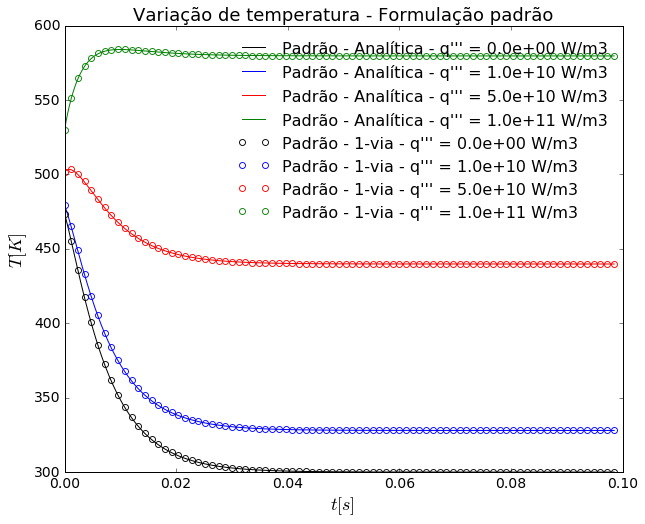

In [20]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_one_way_padrao_hs0-t_one_way_padrao_hs0[0], T_p_RM_standard_hs_0, linestyle = "-", color = "black", 
         label = "Padrão - Analítica - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs0[-1],heat_source[0]))
plt.plot(t_one_way_padrao_hs1-t_one_way_padrao_hs1[0], T_p_RM_standard_hs_1, linestyle = "-", color = "blue", 
         label = "Padrão - Analítica - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs1[-1],heat_source[1]))
plt.plot(t_one_way_padrao_hs2-t_one_way_padrao_hs2[0], T_p_RM_standard_hs_2, linestyle = "-", color = "red", 
         label = "Padrão - Analítica - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs2[-1],heat_source[2]))
plt.plot(t_one_way_padrao_hs3-t_one_way_padrao_hs3[0], T_p_RM_standard_hs_3, linestyle = "-", color = "green", 
         label = "Padrão - Analítica - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs3[-1],heat_source[3]))

plt.plot(t_one_way_padrao_hs0-t_one_way_padrao_hs0[0], temp_one_way_padrao_hs0, linestyle = "None", marker = 'o', 
         markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Padrão - 1-via - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs0[-1],heat_source[0]))
plt.plot(t_one_way_padrao_hs1-t_one_way_padrao_hs1[0], temp_one_way_padrao_hs1, linestyle = "None", marker = 'o', 
         markeredgecolor = "blue",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Padrão - 1-via - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs1[-1],heat_source[1]))
plt.plot(t_one_way_padrao_hs2-t_one_way_padrao_hs2[0], temp_one_way_padrao_hs2, linestyle = "None", marker = 'o', 
         markeredgecolor = "red",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Padrão - 1-via - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs2[-1],heat_source[2]))
plt.plot(t_one_way_padrao_hs3-t_one_way_padrao_hs3[0], temp_one_way_padrao_hs3, linestyle = "None", marker = 'o', 
         markeredgecolor = "green",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Padrão - 1-via - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs3[-1],heat_source[3]))
#plt.plot(t_two_way_padrao_hs0-t_two_way_padrao_hs0[0], temp_two_way_padrao_hs0, linestyle = "None", marker = 'o', 
#         markeredgecolor = "black",  markeredgewidth = 0.9, markevery=15, markerfacecolor = "black", 
#         label = "Padrão - 2-vias - q''' = {1:.1e}".format(Biot_RM_standard_2way_hs0[-1],heat_source[0]))


plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
#plt.ylim(ymax = 500, ymin = 300)
plt.legend(loc = 1, frameon = False, fontsize = 16)
plt.title("Variação de temperatura - Formulação padrão", fontsize = 18)
plt.savefig("termo_fonte_formulacao_padrao.png")
plt.show()



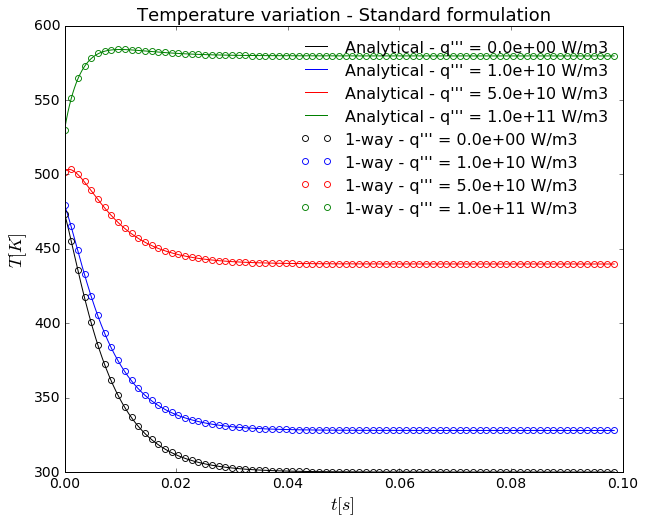

In [13]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_one_way_padrao_hs0-t_one_way_padrao_hs0[0], T_p_RM_standard_hs_0, linestyle = "-", color = "black", 
         label = "Analytical - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs0[-1],heat_source[0]))
plt.plot(t_one_way_padrao_hs1-t_one_way_padrao_hs1[0], T_p_RM_standard_hs_1, linestyle = "-", color = "blue", 
         label = "Analytical - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs1[-1],heat_source[1]))
plt.plot(t_one_way_padrao_hs2-t_one_way_padrao_hs2[0], T_p_RM_standard_hs_2, linestyle = "-", color = "red", 
         label = "Analytical - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs2[-1],heat_source[2]))
plt.plot(t_one_way_padrao_hs3-t_one_way_padrao_hs3[0], T_p_RM_standard_hs_3, linestyle = "-", color = "green", 
         label = "Analytical - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs3[-1],heat_source[3]))

plt.plot(t_one_way_padrao_hs0-t_one_way_padrao_hs0[0], temp_one_way_padrao_hs0, linestyle = "None", marker = 'o', 
         markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "1-way - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs0[-1],heat_source[0]))
plt.plot(t_one_way_padrao_hs1-t_one_way_padrao_hs1[0], temp_one_way_padrao_hs1, linestyle = "None", marker = 'o', 
         markeredgecolor = "blue",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "1-way - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs1[-1],heat_source[1]))
plt.plot(t_one_way_padrao_hs2-t_one_way_padrao_hs2[0], temp_one_way_padrao_hs2, linestyle = "None", marker = 'o', 
         markeredgecolor = "red",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "1-way - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs2[-1],heat_source[2]))
plt.plot(t_one_way_padrao_hs3-t_one_way_padrao_hs3[0], temp_one_way_padrao_hs3, linestyle = "None", marker = 'o', 
         markeredgecolor = "green",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "1-way - q''' = {1:.1e} W/m3".format(Biot_RM_standard_hs3[-1],heat_source[3]))
#plt.plot(t_two_way_padrao_hs0-t_two_way_padrao_hs0[0], temp_two_way_padrao_hs0, linestyle = "None", marker = 'o', 
#         markeredgecolor = "black",  markeredgewidth = 0.9, markevery=15, markerfacecolor = "black", 
#         label = "2-way - q''' = {1:.1e} W/m3".format(Biot_RM_standard_2way_hs0[-1],heat_source[0]))


plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
#plt.ylim(ymax = 500, ymin = 300)
plt.legend( loc = 1, frameon = False, fontsize = 16)
plt.title("Temperature variation - Standard formulation", fontsize = 18)
plt.savefig("termo_fonte_formulacao_padrao_english.png")
plt.show()


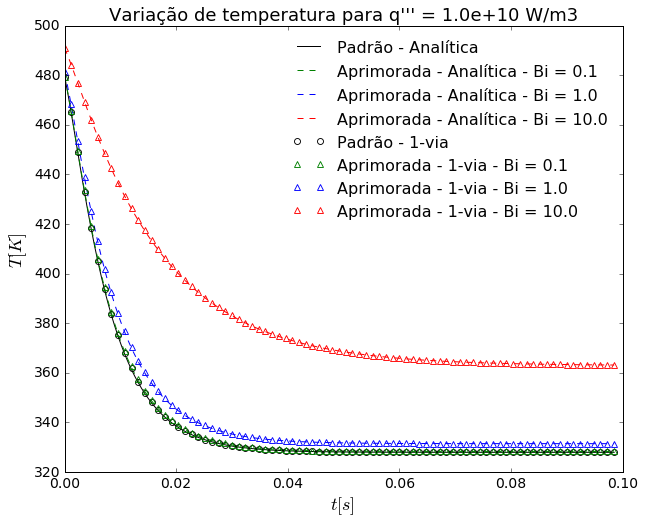

In [21]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)

plt.plot(t_one_way_padrao_hs1-t_one_way_padrao_hs1[0], T_p_RM_standard_hs_1, linestyle = "-", color = "black", 
         label = "Padrão - Analítica")
plt.plot(t_one_way_improved_hs1_Bi01-t_one_way_improved_hs1_Bi01[0], T_p_RM_improved_1_way_hs_1_Bi01, linestyle = "--", color = "green", 
         label = "Aprimorada - Analítica - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi01[-1],heat_source[1]))
plt.plot(t_one_way_improved_hs1_Bi1-t_one_way_improved_hs1_Bi1[0], T_p_RM_improved_1_way_hs_1_Bi1, linestyle = "--", color = "blue", 
         label = "Aprimorada - Analítica - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi1[-1],heat_source[1]))
plt.plot(t_one_way_improved_hs1_Bi10-t_one_way_improved_hs1_Bi10[0], T_p_RM_improved_1_way_hs_1_Bi10, linestyle = "--", color = "red", 
         label = "Aprimorada - Analítica - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi10[-1],heat_source[1]))

plt.plot(t_one_way_padrao_hs1-t_one_way_padrao_hs1[0], temp_one_way_padrao_hs1, linestyle = "None", marker = 'o', 
         markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Padrão - 1-via ")
plt.plot(t_one_way_improved_hs1_Bi01-t_one_way_improved_hs1_Bi01[0], temp_one_way_improved_hs1_Bi01, linestyle = "None", marker = '^', 
         markeredgecolor = "green",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Aprimorada - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi01[-1],heat_source[1]))
plt.plot(t_one_way_improved_hs1_Bi1-t_one_way_improved_hs1_Bi1[0], temp_one_way_improved_hs1_Bi1, linestyle = "None", marker = '^', 
         markeredgecolor = "blue",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Aprimorada - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi1[-1],heat_source[1]))
plt.plot(t_one_way_improved_hs1_Bi10-t_one_way_improved_hs1_Bi10[0], temp_one_way_improved_hs1_Bi10, linestyle = "None", marker = '^', 
         markeredgecolor = "red",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Aprimorada - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi10[-1],heat_source[1]))

plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
#plt.ylim(ymax = 500, ymin = 300)
plt.title("Variação de temperatura para q''' = {0:.1e} W/m3".format(heat_source[1]), fontsize = 18)
plt.legend(loc = 1, frameon = False, fontsize = 16)
plt.savefig("termo_fonte_1_aprimorada_padrao.png")
plt.show()




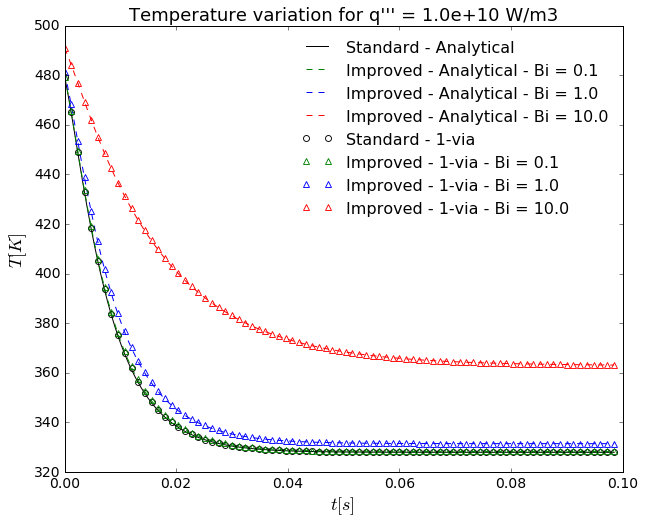

In [31]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)

plt.plot(t_one_way_padrao_hs1-t_one_way_padrao_hs1[0], T_p_RM_standard_hs_1, linestyle = "-", color = "black", 
         label = "Standard - Analytical")
plt.plot(t_one_way_improved_hs1_Bi01-t_one_way_improved_hs1_Bi01[0], T_p_RM_improved_1_way_hs_1_Bi01, linestyle = "--", color = "green", 
         label = "Improved - Analytical - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi01[-1],heat_source[1]))
plt.plot(t_one_way_improved_hs1_Bi1-t_one_way_improved_hs1_Bi1[0], T_p_RM_improved_1_way_hs_1_Bi1, linestyle = "--", color = "blue", 
         label = "Improved - Analytical - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi1[-1],heat_source[1]))
plt.plot(t_one_way_improved_hs1_Bi10-t_one_way_improved_hs1_Bi10[0], T_p_RM_improved_1_way_hs_1_Bi10, linestyle = "--", color = "red", 
         label = "Improved - Analytical - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi10[-1],heat_source[1]))

plt.plot(t_one_way_padrao_hs1-t_one_way_padrao_hs1[0], temp_one_way_padrao_hs1, linestyle = "None", marker = 'o', 
         markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Standard - 1-via ")
plt.plot(t_one_way_improved_hs1_Bi01-t_one_way_improved_hs1_Bi01[0], temp_one_way_improved_hs1_Bi01, linestyle = "None", marker = '^', 
         markeredgecolor = "green",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Improved - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi01[-1],heat_source[1]))
plt.plot(t_one_way_improved_hs1_Bi1-t_one_way_improved_hs1_Bi1[0], temp_one_way_improved_hs1_Bi1, linestyle = "None", marker = '^', 
         markeredgecolor = "blue",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Improved - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi1[-1],heat_source[1]))
plt.plot(t_one_way_improved_hs1_Bi10-t_one_way_improved_hs1_Bi10[0], temp_one_way_improved_hs1_Bi10, linestyle = "None", marker = '^', 
         markeredgecolor = "red",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Improved - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs1_Bi10[-1],heat_source[1]))

plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
#plt.ylim(ymax = 500, ymin = 300)
plt.title("Temperature variation for q''' = {0:.1e} W/m3".format(heat_source[1]), fontsize = 18)
plt.legend(loc = 1, frameon = False, fontsize = 16)
plt.savefig("termo_fonte_1_aprimorada_padrao_english.png")
plt.show()

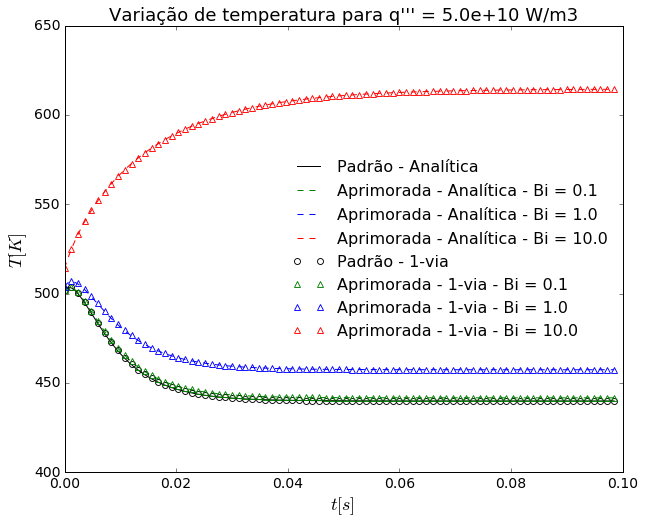

In [32]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)

plt.plot(t_one_way_padrao_hs2-t_one_way_padrao_hs2[0], T_p_RM_standard_hs_2, linestyle = "-", color = "black", 
         label = "Padrão - Analítica")
plt.plot(t_one_way_improved_hs2_Bi01-t_one_way_improved_hs2_Bi01[0], T_p_RM_improved_1_way_hs_2_Bi01, linestyle = "--", color = "green", 
         label = "Aprimorada - Analítica - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi01[-1],heat_source[2]))
plt.plot(t_one_way_improved_hs2_Bi1-t_one_way_improved_hs2_Bi1[0], T_p_RM_improved_1_way_hs_2_Bi1, linestyle = "--", color = "blue", 
         label = "Aprimorada - Analítica - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi1[-1],heat_source[2]))
plt.plot(t_one_way_improved_hs2_Bi10-t_one_way_improved_hs2_Bi10[0], T_p_RM_improved_1_way_hs_2_Bi10, linestyle = "--", color = "red", 
         label = "Aprimorada - Analítica - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi10[-1],heat_source[2]))

plt.plot(t_one_way_padrao_hs2-t_one_way_padrao_hs2[0], temp_one_way_padrao_hs2, linestyle = "None", marker = 'o', 
         markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Padrão - 1-via ")
plt.plot(t_one_way_improved_hs2_Bi01-t_one_way_improved_hs2_Bi01[0], temp_one_way_improved_hs2_Bi01, linestyle = "None", marker = '^', 
         markeredgecolor = "green",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Aprimorada - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi01[-1],heat_source[2]))
plt.plot(t_one_way_improved_hs2_Bi1-t_one_way_improved_hs2_Bi1[0], temp_one_way_improved_hs2_Bi1, linestyle = "None", marker = '^', 
         markeredgecolor = "blue",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Aprimorada - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi1[-1],heat_source[2]))
plt.plot(t_one_way_improved_hs2_Bi10-t_one_way_improved_hs2_Bi10[0], temp_one_way_improved_hs2_Bi10, linestyle = "None", marker = '^', 
         markeredgecolor = "red",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Aprimorada - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi10[-1],heat_source[2]))

plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
#plt.ylim(ymax = 500, ymin = 300)
plt.title("Variação de temperatura para q''' = {0:.1e} W/m3".format(heat_source[2]), fontsize = 18)
plt.legend(loc = 5, frameon = False, fontsize = 16)
plt.savefig("termo_fonte_2_aprimorada_padrao.png")
plt.show()

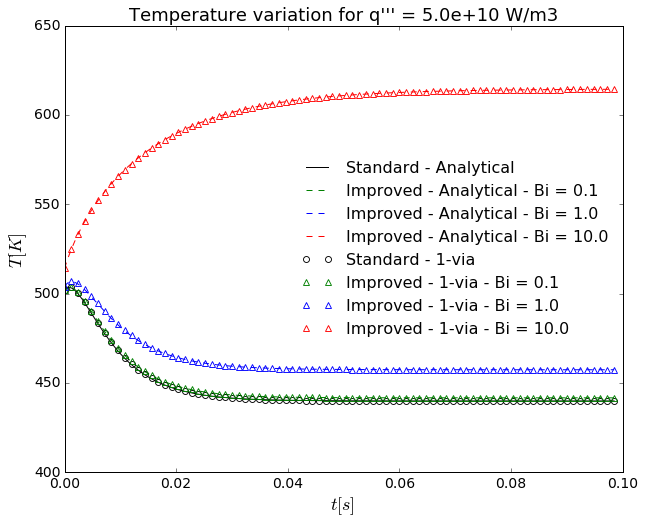

In [33]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)

plt.plot(t_one_way_padrao_hs2-t_one_way_padrao_hs2[0], T_p_RM_standard_hs_2, linestyle = "-", color = "black", 
         label = "Standard - Analytical")
plt.plot(t_one_way_improved_hs2_Bi01-t_one_way_improved_hs2_Bi01[0], T_p_RM_improved_1_way_hs_2_Bi01, linestyle = "--", color = "green", 
         label = "Improved - Analytical - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi01[-1],heat_source[2]))
plt.plot(t_one_way_improved_hs2_Bi1-t_one_way_improved_hs2_Bi1[0], T_p_RM_improved_1_way_hs_2_Bi1, linestyle = "--", color = "blue", 
         label = "Improved - Analytical - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi1[-1],heat_source[2]))
plt.plot(t_one_way_improved_hs2_Bi10-t_one_way_improved_hs2_Bi10[0], T_p_RM_improved_1_way_hs_2_Bi10, linestyle = "--", color = "red", 
         label = "Improved - Analytical - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi10[-1],heat_source[2]))

plt.plot(t_one_way_padrao_hs2-t_one_way_padrao_hs2[0], temp_one_way_padrao_hs2, linestyle = "None", marker = 'o', 
         markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Standard - 1-via ")
plt.plot(t_one_way_improved_hs2_Bi01-t_one_way_improved_hs2_Bi01[0], temp_one_way_improved_hs2_Bi01, linestyle = "None", marker = '^', 
         markeredgecolor = "green",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Improved - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi01[-1],heat_source[2]))
plt.plot(t_one_way_improved_hs2_Bi1-t_one_way_improved_hs2_Bi1[0], temp_one_way_improved_hs2_Bi1, linestyle = "None", marker = '^', 
         markeredgecolor = "blue",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Improved - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi1[-1],heat_source[2]))
plt.plot(t_one_way_improved_hs2_Bi10-t_one_way_improved_hs2_Bi10[0], temp_one_way_improved_hs2_Bi10, linestyle = "None", marker = '^', 
         markeredgecolor = "red",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Improved - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs2_Bi10[-1],heat_source[2]))

plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
#plt.ylim(ymax = 500, ymin = 300)
plt.title("Temperature variation for q''' = {0:.1e} W/m3".format(heat_source[2]), fontsize = 18)
plt.legend(loc = 5, frameon = False, fontsize = 16)
plt.savefig("termo_fonte_2_aprimorada_padrao_english.png")
plt.show()

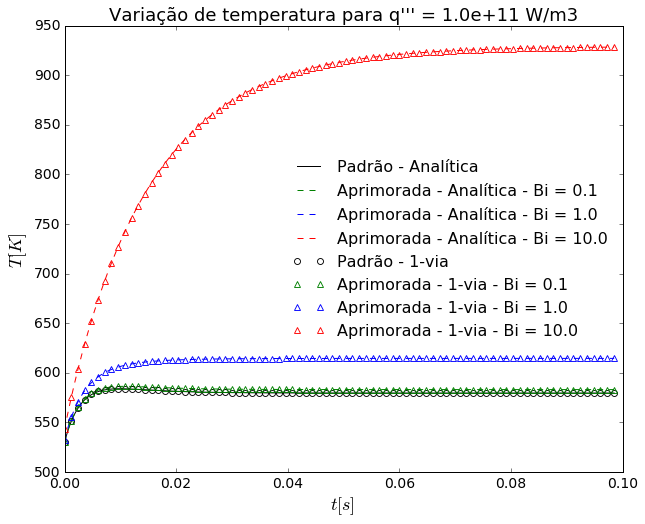

In [23]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)

plt.plot(t_one_way_padrao_hs3-t_one_way_padrao_hs3[0], T_p_RM_standard_hs_3, linestyle = "-", color = "black", 
         label = "Padrão - Analítica")
plt.plot(t_one_way_improved_hs3_Bi01-t_one_way_improved_hs3_Bi01[0], T_p_RM_improved_1_way_hs_3_Bi01, linestyle = "--", color = "green", 
         label = "Aprimorada - Analítica - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi01[-1],heat_source[3]))
plt.plot(t_one_way_improved_hs3_Bi1-t_one_way_improved_hs3_Bi1[0], T_p_RM_improved_1_way_hs_3_Bi1, linestyle = "--", color = "blue", 
         label = "Aprimorada - Analítica - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi1[-1],heat_source[3]))
plt.plot(t_one_way_improved_hs3_Bi10-t_one_way_improved_hs3_Bi10[0], T_p_RM_improved_1_way_hs_3_Bi10, linestyle = "--", color = "red", 
         label = "Aprimorada - Analítica - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi10[-1],heat_source[3]))

plt.plot(t_one_way_padrao_hs3-t_one_way_padrao_hs3[0], temp_one_way_padrao_hs3, linestyle = "None", marker = 'o', 
         markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Padrão - 1-via ")
plt.plot(t_one_way_improved_hs3_Bi01-t_one_way_improved_hs3_Bi01[0], temp_one_way_improved_hs3_Bi01, linestyle = "None", marker = '^', 
         markeredgecolor = "green",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Aprimorada - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi01[-1],heat_source[3]))
plt.plot(t_one_way_improved_hs3_Bi1-t_one_way_improved_hs3_Bi1[0], temp_one_way_improved_hs3_Bi1, linestyle = "None", marker = '^', 
         markeredgecolor = "blue",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Aprimorada - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi1[-1],heat_source[3]))
plt.plot(t_one_way_improved_hs3_Bi10-t_one_way_improved_hs3_Bi10[0], temp_one_way_improved_hs3_Bi10, linestyle = "None", marker = '^', 
         markeredgecolor = "red",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Aprimorada - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi10[-1],heat_source[3]))

plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
#plt.ylim(ymax = 500, ymin = 300)
plt.title("Variação de temperatura para q''' = {0:.1e} W/m3".format(heat_source[3]), fontsize = 18)
plt.legend(loc = 5, frameon = False, fontsize = 16)
plt.savefig("termo_fonte_3_aprimorada_padrao.png")
plt.show()

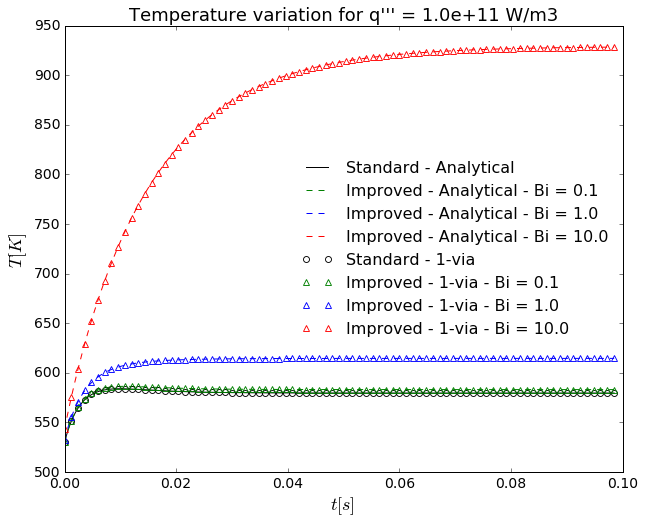

In [35]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)

plt.plot(t_one_way_padrao_hs3-t_one_way_padrao_hs3[0], T_p_RM_standard_hs_3, linestyle = "-", color = "black", 
         label = "Standard - Analytical")
plt.plot(t_one_way_improved_hs3_Bi01-t_one_way_improved_hs3_Bi01[0], T_p_RM_improved_1_way_hs_3_Bi01, linestyle = "--", color = "green", 
         label = "Improved - Analytical - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi01[-1],heat_source[3]))
plt.plot(t_one_way_improved_hs3_Bi1-t_one_way_improved_hs3_Bi1[0], T_p_RM_improved_1_way_hs_3_Bi1, linestyle = "--", color = "blue", 
         label = "Improved - Analytical - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi1[-1],heat_source[3]))
plt.plot(t_one_way_improved_hs3_Bi10-t_one_way_improved_hs3_Bi10[0], T_p_RM_improved_1_way_hs_3_Bi10, linestyle = "--", color = "red", 
         label = "Improved - Analytical - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi10[-1],heat_source[3]))

plt.plot(t_one_way_padrao_hs3-t_one_way_padrao_hs3[0], temp_one_way_padrao_hs3, linestyle = "None", marker = 'o', 
         markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Standard - 1-via ")
plt.plot(t_one_way_improved_hs3_Bi01-t_one_way_improved_hs3_Bi01[0], temp_one_way_improved_hs3_Bi01, linestyle = "None", marker = '^', 
         markeredgecolor = "green",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Improved - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi01[-1],heat_source[3]))
plt.plot(t_one_way_improved_hs3_Bi1-t_one_way_improved_hs3_Bi1[0], temp_one_way_improved_hs3_Bi1, linestyle = "None", marker = '^', 
         markeredgecolor = "blue",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Improved - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi1[-1],heat_source[3]))
plt.plot(t_one_way_improved_hs3_Bi10-t_one_way_improved_hs3_Bi10[0], temp_one_way_improved_hs3_Bi10, linestyle = "None", marker = '^', 
         markeredgecolor = "red",  markeredgewidth = 0.9, markevery=12, markerfacecolor = "none", 
         label = "Improved - 1-via - Bi = {0:.1f}".format(Biot_RM_improved_one_way_hs3_Bi10[-1],heat_source[3]))

plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
#plt.ylim(ymax = 500, ymin = 300)
plt.title("Temperature variation for q''' = {0:.1e} W/m3".format(heat_source[3]), fontsize = 18)
plt.legend(loc = 5, frameon = False, fontsize = 16)
plt.savefig("termo_fonte_3_aprimorada_padrao_english.png")
plt.show()